Data Collection

In [ ]:
!pip install newsapi-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from newsapi import NewsApiClient
import pandas as pd
import numpy as np
import os

news_api_key = os.environ.get('news_api_key')
newsapi = NewsApiClient(api_key=news_api_key)

In [ ]:
news_queries = [
    'OpenAI releases new model',
    'OpenAI',
]

In [ ]:
import time

# search for news articles
articles = []
for query in news_queries:
  results = newsapi.get_everything(q=query,
                                        language='en',
                                        sort_by='relevancy',
                                        page=1)
  time.sleep(1)
  articles.append(results)
article = pd.concat([pd.DataFrame(result['articles']) for result in articles])

In [ ]:
article

source  \
0                 {'id': None, 'name': 'Gizmodo.com'}   
1                {'id': None, 'name': 'The Guardian'}   
2   {'id': 'business-insider', 'name': 'Business I...   
3                {'id': None, 'name': 'The Guardian'}   
4                {'id': None, 'name': 'Substack.com'}   
..                                                ...   
95                 {'id': None, 'name': 'Github.com'}   
96               {'id': None, 'name': 'The Guardian'}   
97               {'id': None, 'name': 'The Guardian'}   
98               {'id': None, 'name': 'The Guardian'}   
99             {'id': None, 'name': 'Digital Trends'}   

                                      author  \
0                                  Kyle Barr   
1                              John Naughton   
2   hchowdhury@insider.com (Hasan Chowdhury)   
3                             Stuart Russell   
4                               Ryan Shannon   
..                                       ...   
95                                    openai   
96                             John Naughton   
97                                 Alex Hern   
98            Alex Hern UK technology editor   
99                                Alan Truly   

                                                title  \
0   Meta Releases New AI-Based Photo Segmentation ...   
1   You wait ages for an AI chatbot to come along,...   
2   Tech firms hold all the power right now as Gol...   
3   AI has much to offer humanity. It could also w...   
4   Keeping up with the overwhelming pace of AI in...   
..                                                ...   
95                           ChatGPT Retrieval Plugin   
96  You wait ages for an AI chatbot to come along,...   
97  Elon Musk promised to take away the blue ticks...   
98  Elon Musk joins call for pause in creation of ...   
99  ChatGPT just plugged itself into the internet....   

                                          description  \
0   Meta has some big AI ambitions, even as it see...   
1   The fact that ChatGPT isn’t the only machine-l...   
2   Goldman Sachs estimates 300 million jobs could...   
3   Systems with abilities exceeding human capacit...   
4   Or, what increasingly feels like we're living ...   
..                                                ...   
95  Contribute to openai/chatgpt-retrieval-plugin ...   
96  The fact that ChatGPT isn’t the only machine-l...   
97  After weeks of warnings, Twitter appears to ha...   
98  Steve Wozniak and DeepMind, Meta, Miscrosoft, ...   
99  OpenAI is providing internet access to ChatGPT...   

                                                  url  \
0   https://gizmodo.com/meta-ai-sam-photo-segmenta...   
1   https://www.theguardian.com/commentisfree/2023...   
2   https://www.businessinsider.com/tech-holds-the...   
3   https://www.theguardian.com/commentisfree/2023...   
4   https://ryanshannon.substack.com/p/keeping-up-...   
..                                                ...   
95  https://github.com/openai/chatgpt-retrieval-pl...   
96  https://www.theguardian.com/commentisfree/2023...   
97  https://www.theguardian.com/technology/2023/ap...   
98  https://www.theguardian.com/technology/2023/ma...   
99  https://www.digitaltrends.com/computing/chatgp...   

                                           urlToImage           publishedAt  \
0   https://i.kinja-img.com/gawker-media/image/upl...  2023-04-05T19:25:00Z   
1   https://i.guim.co.uk/img/media/627962723bc07f6...  2023-03-25T16:00:53Z   
2   https://i.insider.com/64241c03b643e80019df4867...  2023-03-29T16:17:17Z   
3   https://i.guim.co.uk/img/media/63269341070b093...  2023-04-02T07:00:14Z   
4   https://substackcdn.com/image/fetch/w_1200,h_6...  2023-03-28T17:35:47Z   
..                                                ...                   ...   
95  https://opengraph.githubassets.com/228cadd5d4d...  2023-03-23T17:51:01Z   
96  https://i.guim.co.uk/img/media/627962723bc07f6...  2023-03-25T16:00:53Z   
97  https://i.guim.

In [ ]:
article.drop_duplicates('title', inplace=True)
len(article)

185

In [ ]:
# Extract text from webpages
from bs4 import BeautifulSoup
from tqdm import tqdm
import requests

def get_article_text(url, content_tag='p', content_class=None):
    try:
        response = requests.get(url, timeout=10)
    except requests.exceptions.RequestException as e:
        print(e)
        return None
    soup = BeautifulSoup(response.content, 'html.parser')

    if content_class:
        content = soup.find_all(content_tag, class_=content_class)
    else:
        content = soup.find_all(content_tag)

    text = ' '.join([p.get_text() for p in content])
    return text.strip()

# article['text'] = article['url'].apply(get_article_text)

texts = []
for url in tqdm(article['url']):
  texts.append(get_article_text(url))

article['text'] = texts

100%|██████████| 185/185 [01:56<00:00,  1.59it/s]


In [ ]:
scraped = article.copy()
%store scraped

Stored 'scraped' (DataFrame)


In [ ]:
%store -r scraped
article = scraped

In [ ]:
def chunk_text(text, words_per_chunk):
    """
    Splits a given text into chunks based on the specified number of words per chunk.

    Args:
        text (str): The text to be chunked.
        words_per_chunk (int): The maximum number of words allowed in each chunk.

    Returns:
        list: A list of chunks, where each chunk is a string representing a portion of the original text.
    """
    if not text:
        return None
    sentences = text.split('.')
    words_per_sentence = [len(s.split()) for s in sentences]

    chunks = []
    chunk = ''
    for i, sentence in enumerate(sentences):
        if len(chunk.split()) + words_per_sentence[i] > words_per_chunk:
            chunks.append(chunk)
            chunk = ''
        chunk += sentence + '.'
    chunks.append(chunk)
    return chunks

In [ ]:
article.dropna(subset='text', inplace=True)
article

source  \
0                 {'id': None, 'name': 'Gizmodo.com'}   
1                {'id': None, 'name': 'The Guardian'}   
2   {'id': 'business-insider', 'name': 'Business I...   
3                {'id': None, 'name': 'The Guardian'}   
4                {'id': None, 'name': 'Substack.com'}   
..                                                ...   
94                   {'id': 'wired', 'name': 'Wired'}   
95                 {'id': None, 'name': 'Github.com'}   
97               {'id': None, 'name': 'The Guardian'}   
98               {'id': None, 'name': 'The Guardian'}   
99             {'id': None, 'name': 'Digital Trends'}   

                                      author  \
0                                  Kyle Barr   
1                              John Naughton   
2   hchowdhury@insider.com (Hasan Chowdhury)   
3                             Stuart Russell   
4                               Ryan Shannon   
..                                       ...   
94                              Michal Luria   
95                                    openai   
97                                 Alex Hern   
98            Alex Hern UK technology editor   
99                                Alan Truly   

                                                title  \
0   Meta Releases New AI-Based Photo Segmentation ...   
1   You wait ages for an AI chatbot to come along,...   
2   Tech firms hold all the power right now as Gol...   
3   AI has much to offer humanity. It could also w...   
4   Keeping up with the overwhelming pace of AI in...   
..                                                ...   
94  Your ChatGPT Relationship Status Shouldn’t Be ...   
95                           ChatGPT Retrieval Plugin   
97  Elon Musk promised to take away the blue ticks...   
98  Elon Musk joins call for pause in creation of ...   
99  ChatGPT just plugged itself into the internet....   

                                          description  \
0   Meta has some big AI ambitions, even as it see...   
1   The fact that ChatGPT isn’t the only machine-l...   
2   Goldman Sachs estimates 300 million jobs could...   
3   Systems with abilities exceeding human capacit...   
4   Or, what increasingly feels like we're living ...   
..                                                ...   
94  The way people talk to each other is influence...   
95  Contribute to openai/chatgpt-retrieval-plugin ...   
97  After weeks of warnings, Twitter appears to ha...   
98  Steve Wozniak and DeepMind, Meta, Miscrosoft, ...   
99  OpenAI is providing internet access to ChatGPT...   

                                                  url  \
0   https://gizmodo.com/meta-ai-sam-photo-segmenta...   
1   https://www.theguardian.com/commentisfree/2023...   
2   https://www.businessinsider.com/tech-holds-the...   
3   https://www.theguardian.com/commentisfree/2023...   
4   https://ryanshannon.substack.com/p/keeping-up-...   
..                                                ...   
94  https://www.wired.com/story/chatgpt-social-rol...   
95  https://github.com/openai/chatgpt-retrieval-pl...   
97  https://www.theguardian.com/technology/2023/ap...   
98  https://www.theguardian.com/technology/2023/ma...   
99  https://www.digitaltrends.com/computing/chatgp...   

                                           urlToImage           publishedAt  \
0   https://i.kinja-img.com/gawker-media/image/upl...  2023-04-05T19:25:00Z   
1   https://i.guim.co.uk/img/media/627962723bc07f6...  2023-03-25T16:00:53Z   
2   https://i.insider.com/64241c03b643e80019df4867...  2023-03-29T16:17:17Z   
3   https://i.guim.co.uk/img/media/63269341070b093...  2023-04-02T07:00:14Z   
4   https://substackcdn.com/image/fetch/w_1200,h_6...  2023-03-28T17:35:47Z   
..                                                ...                   ...   
94  https://media.wired.com/photos/6434943a5b843d0...  2023-04-11T13:00:00Z   
95  https://opengraph.githubassets.com/228cadd5d4d...  2023-03-23T17:51:01Z   
97  https://i.guim.

In [ ]:
"""
This code expands the dataframe to have one row per chunk, including the chunk number and total number of chunks.
It first resets the index of the dataframe and then applies the 'chunk_text' function to the 'text' column to split the text into chunks of 80 characters.
Any rows with missing chunks are dropped from the dataframe.
The code then adds the description to the list of chunks for each article, and explodes the 'chunk' column to create separate rows for each chunk.
The 'chunk_num' column is created to represent the chunk number within each article, and the 'total_chunks' column is created to represent the total number of chunks for each article.
"""

article.reset_index(drop=True, inplace=True)
article['chunk'] = article['text'].apply(chunk_text, args=(80,))
article = article.dropna(subset=['chunk'])

for i, row in article.iterrows():
  if row['chunk']:
    article.loc[i, 'chunk'].append(row['description'])
  else:
    article.loc[i, 'chunk'] = [row['description']]

article = article.explode('chunk')
article['chunk_num'] = article.groupby('title').cumcount()
article['total_chunks'] = article.groupby('title').transform('count')['chunk'] - 1


<Axes: ylabel='Frequency'>

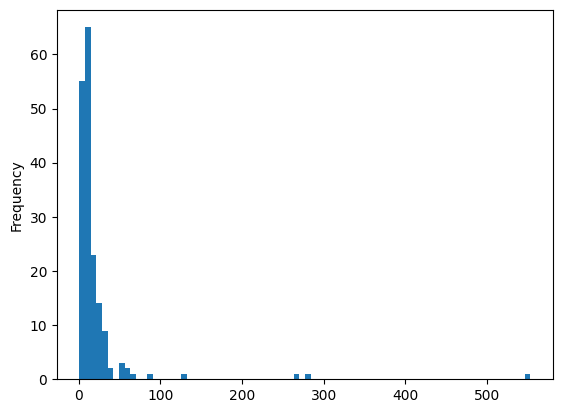

In [ ]:
article.drop_duplicates('title')['total_chunks'].plot.hist(bins=80)

In [ ]:
article = article.drop_duplicates(subset=['chunk'])

# Data Processing

In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
# Compute embeddings for each chunk
embeddings = []
for chunk in tqdm(article['chunk']):
  if chunk:
    embeddings.append(embedding_model.encode(chunk))
  else:
    embeddings.append(None)
article['embedding'] = embeddings

processed = article.copy()
%store processed

100%|██████████| 3861/3861 [04:35<00:00, 14.02it/s]


Stored 'processed' (DataFrame)


In [ ]:
%store -r processed
article = processed

In [ ]:
article.dropna(subset=['embedding'], inplace=True)
article.reset_index(drop=True, inplace=True)

# Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import sys
import time
import datetime
from textwrap import fill

In [ ]:
# if 'sentiment' in df.columns:
#     df['sentiment_negative'] = df.sentiment.apply(lambda x: x[0][0])
#     df['sentiment_positive'] = df.sentiment.apply(lambda x: x[0][1])
#     df.drop(columns=['sentiment'], inplace=True)

In [ ]:
# plt.plot(df.sentiment_negative, df.sentiment_positive, 'o', alpha=0.1)
# They are highly inversly correlated. Convert to a single score. 0: neagtive, 1: positive

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# pca = PCA(n_components=1)
# scaler = MinMaxScaler()

# sentiment = pca.fit_transform(df[['sentiment_negative', 'sentiment_positive']])
# sentiment = scaler.fit_transform(sentiment)

# df['sentiment'] = sentiment
# df.drop(columns=['sentiment_negative', 'sentiment_positive'], inplace=True)

In [ ]:
# _ = plt.hist(df['sentiment'], bins=500)

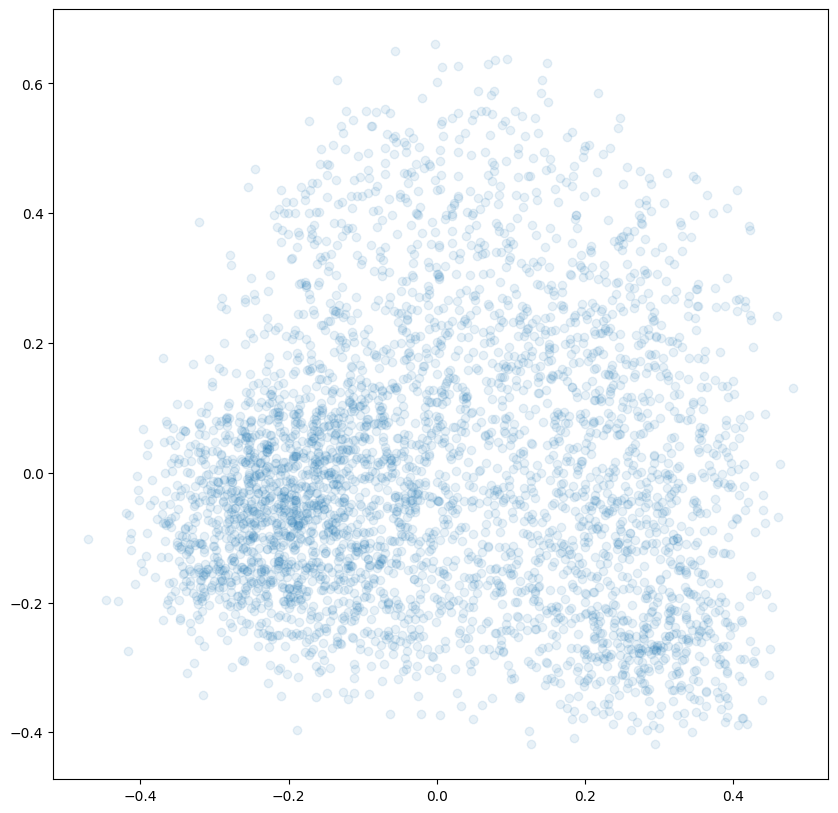

In [ ]:
vecs = np.stack(article.embedding)
pca = PCA(n_components=2)
vecs = pca.fit_transform(vecs)
plt.figure(figsize=(10, 10))
plt.scatter(vecs[:, 0], vecs[:, 1], alpha=0.1)

In [ ]:
vecs = np.stack(article.embedding)
pca_3d = PCA(n_components=3)
vecs = pca_3d.fit_transform(vecs)
px.scatter_3d(x=vecs[:, 0], y=vecs[:, 1], z=vecs[:, 2], opacity=0.3, hover_name=article.title, hover_data=[article.chunk.apply(fill, args=(10,))])

Observation: The dark points are duplicate text. Text that is repeated on every site from the same publisher. Those points are further from the rest. Also, there seems to be two clusters. Lets train an svm to predict if a chunk is that generic website text.

In [ ]:
# search for starting data
queries = embedding_model.encode([
    'New model released',
])
queries.shape

(1, 384)

In [ ]:
vecs = np.stack(article.embedding)

from sklearn.metrics.pairwise import cosine_distances

distances = cosine_distances(vecs, queries)
search_results = distances.max(axis=1).argsort()

In [ ]:
def get_text(index):
    return article.iloc[index].chunk

In [ ]:
idx = 11
print(fill(get_text(search_results[idx]), 100))
# print(distances.max(axis=1).argsort()[idx])

’s GPUs, until now none has been able to demonstrate the ability to train large-scale models and
open source those efforts with permissive licenses. On the contrary, Cerebras says that competitive
pressures have resulted in less willingness to make LLMs publicly available, meaning they remain
largely inaccessible. That’s what Cerebras is hoping to address with today’s release. It’s open-
sourcing a series of seven GPT models with 111 million, 256 million, 590 million, 1.3 billion, 2.7
billion, 6.


In [ ]:
positive_example_idx = [1, 7]

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import VBox
from IPython.display import display, Javascript

# Create a placeholder for labels, initialized to -1
labels = np.full(article.shape[0], -1, dtype=int)
labels[positive_example_idx] = 1

# Use the entire dataset for training
X_train = np.stack(article.embedding)
y_train = labels

# Define the SVC model
svc = SVC(probability=True)

# Active learning loop
from sklearn.exceptions import NotFittedError

def active_learning_callback(button):
    global current_iteration

    # Update the labels
    for i, checkbox in enumerate(checkboxes):
        if checkbox.value:
            y_train[indices[i]] = 1
        else:
            y_train[indices[i]] = 0

    print("Labels saved.")

    # Increment the current_iteration counter and call active_learning_step
    current_iteration += 1
    active_learning_step()

submit_button = widgets.Button(description="Submit")
submit_button.on_click(active_learning_callback)

current_iteration = 1
num_iterations = 10
num_examples = 5

def active_learning_step():
    """
    Performs one iteration of active learning.

    This function trains the model on labeled data, predicts on the labeled training set,
    selects the most uncertain examples, and displays them for labeling.

    Returns:
        None
    """
    global indices, checkboxes, uncertain_examples_prob

    clear_output(wait=True)

    print(f"Iteration {current_iteration}/{num_iterations}")

    # Train the model on labeled data
    if np.sum(y_train != -1) > 1 and len(np.unique(y_train[y_train != -1])) > 1:
        labeled_indices = y_train != -1
        unique_labels, counts = np.unique(y_train[labeled_indices], return_counts=True)

        # Check if both classes have at least one sample
        if len(unique_labels) > 1 and all(counts > 0):
            svc.fit(X_train[labeled_indices], y_train[labeled_indices])

            # Predict on the labeled training set and print the confusion matrix
            y_pred_train = svc.predict(X_train[labeled_indices])
            print("Confusion Matrix (Labeled Training Set):")
            print(confusion_matrix(y_train[labeled_indices], y_pred_train))

    # Query the most uncertain examples
    try:
        uncertain_examples = svc.predict_proba(X_train[y_train == -1]).max(axis=1).argsort()[:num_examples]
        uncertain_examples_prob = svc.predict_proba(X_train[y_train == -1])[uncertain_examples]
        print("Selected uncertain examples:", uncertain_examples)
    except NotFittedError:
        print("The model is not fitted yet. Please provide some initial labels.")
        uncertain_examples = np.random.choice(np.arange(X_train.shape[0])[y_train == -1], size=num_examples, replace=False)
        uncertain_examples_prob = np.full((num_examples, 2), 0.5)  # Placeholder probabilities for the initial iteration

    indices = np.arange(X_train.shape[0])[y_train == -1][uncertain_examples]

    print(f"Please label the following {num_examples} examples:")

    # Display the text chunks for labeling (you'll need to implement the 'get_text' function)
    checkboxes = []
    for i, index in enumerate(indices):
        text_chunk = get_text(index)  # Implement this function to map an index back to the text chunk
        prob_class_1 = uncertain_examples_prob[i][1]
        checkbox = widgets.Checkbox(description="Positive Example", value=False)
        checkboxes.append(checkbox)
        display(VBox([widgets.HTML(value=f"<p style='word-wrap: break-word;'>{text_chunk} (Predicted probability of Class 1: {prob_class_1:.2f})</p>"), checkbox]))

    # Display submit button for user input
    display(submit_button)

def active_learning_loop():
    global current_iteration
    current_iteration = 1
    active_learning_step()

active_learning_loop()

Iteration 27/10
Confusion Matrix (Labeled Training Set):
[[97  0]
 [15 20]]
Selected uncertain examples: [648 653 655 261 958]
Please label the following 5 examples:


Button(description='Submit', style=ButtonStyle())

In [ ]:
article.loc[450, 'url']

'https://markets.businessinsider.com/news/stocks/stock-market-news-today-goldman-sachs-tesla-netflix-earnings-inflation-2023-4'

In [ ]:
import pickle

with open('svc_Applications_of_LLMs.pickle', 'wb') as f:
    pickle.dump(svc, f)

In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_3d_decision_boundary(model, pca_model, points):
    # Create a mesh grid for the 3D PCA space
    step = 0.1
    x_range = np.arange(-0.7, 0.7, step)
    y_range = np.arange(-0.7, 0.7, step)
    z_range = np.arange(-0.7, 0.7, step)
    x_mesh, y_mesh, z_mesh = np.meshgrid(x_range, y_range, z_range)

    # Reshape the mesh grid into a format suitable for input to the model
    mesh_points = np.c_[x_mesh.ravel(), y_mesh.ravel(), z_mesh.ravel()]

    # Predict the class labels for the mesh points
    full_dims = pca_model.inverse_transform(mesh_points)
    y_pred = model.predict(full_dims)

    # Reshape the predicted labels back into the shape of the mesh grid
    y_pred_mesh = y_pred.reshape(x_mesh.shape)

    # Plot the decision boundary
    fig = go.Figure()
    fig.add_trace(go.Volume(x=x_mesh.flatten(), y=y_mesh.flatten(), z=z_mesh.flatten(),
                            value=y_pred_mesh.flatten(),
                            isomin=0.5, isomax=0.5,
                            opacity=0.4, surface_count=1))
    fig.add_trace(go.Scatter3d(x=points[:, 0], y=points[:, 1], z=points[:, 2],
                               mode='markers', marker=dict(size=5, color=svc.predict(np.stack(article.embedding)), opacity=0.4)))

    fig.update_layout(scene=dict(aspectmode='data'))
    fig.write_html('boundary_line.html')
    fig.show()

vecs = np.stack(article.embedding)
pca_3d = PCA(n_components=3)
vecs_3d = pca_3d.fit_transform(vecs)


plot_3d_decision_boundary(svc, pca_3d, vecs_3d)


In [ ]:
X_test = X_train[y_train == -1]
y_pred = svc.predict_proba(X_test)
indices = np.arange(X_train.shape[0])[y_train == -1]
texts = [get_text(idx) for idx in indices]

# Show random samples of unlabled samples

samples = np.random.randint(0, len(texts), 5)
for sample in samples:
  print(fill(texts[sample], 100))
  print(y_pred[sample], end='\n\n')

 In my world view, we do not create new inventions, we discover them by trial and error. After
billions of years, biological evolution has not perfected our thinking ability. I do not expect
perfection after less than 100 years of trying to discover thinking machines, but from what I have
seen I am convinced we are on a fruitful path. My neural networks might be mistaken, of course.
[0.98650761 0.01349239]

 I do NOT believe that such ability to invent will be ’emergent’. LM can today invent multiple
techniques for computing primes and 80k other OEIS sequences from scratch –
https://doi.org/10.48550/arXiv.2301.11479 .  (Summary/discussion here: https://avva-livejournal-
com.translate.goog/3523103.html?_x_tr_sl=auto&_x_tr_tl=en&_x_tr_hl=en&_x_tr_pto=wapp ). Some
complain that ChatGPT can’t invent anything new; others, that it invents too much.
[0.95813153 0.04186847]

It’s going to take more than ‘Uber for Trucks’ to bring the freight industry into the future Videos
by a group dubbed th

In [ ]:
most_confident = y_pred[:,1].argsort()[::-1][:50] #

for idx in most_confident:
  print(fill(texts[idx], 100))
  print(y_pred[idx], end='\n\n')

Chinese firm Alibaba on Tuesday introduced Tongyi Qianwen, an AI-powered language model similar to
GPT. At the same time, Beijing revealed a draft law that new AI must "reflect socialist values." The
new AI model Tongyi Qianwen — which means "truth from a tho…
[0.06203961 0.93796039]

 This enhanced LLM support is delivered through: "The native support of Hugging Face transformers
library in MLflow makes it easy to work with over 170,000 free and publicly accessible machine
learning models available on the Hugging Face Hub, the largest community and open platform for AI."
- Jeff Boudier, Product Director, Hugging Face The new transformers flavor brings native integration
of transformers pipelines, models, and processing components to the MLflow tracking service.
[0.63663679 0.36336321]

 It includes a predefined set of classes that map to OpenAI API resources. Usage of these provided
classes will dynamically initialize connection, passing of data to, and retrieval of responses from
a w

In [ ]:
# save the model's predictions to the df
article['Positive Class'] = svc.predict(np.stack(article.embedding.values))
article['relevancy'] = svc.predict_proba(np.stack(article.embedding))[:,1]
article['was_labeled'] = y_train != -1

In [ ]:
article['source'] = article['source'].apply(lambda x: x['name'])
article

source                 author  \
0          CNN  Samantha Murphy Kelly   
1          CNN  Samantha Murphy Kelly   
2          CNN  Samantha Murphy Kelly   
3          CNN  Samantha Murphy Kelly   
4          CNN  Samantha Murphy Kelly   
...        ...                    ...   
3705  TechSpot           Julio Franco   
3706  TechSpot           Julio Franco   
3707  TechSpot           Julio Franco   
3708  TechSpot           Julio Franco   
3709  TechSpot           Julio Franco   

                                                  title  \
0     5 jaw-dropping things GPT-4 can do that ChatGP...   
1     5 jaw-dropping things GPT-4 can do that ChatGP...   
2     5 jaw-dropping things GPT-4 can do that ChatGP...   
3     5 jaw-dropping things GPT-4 can do that ChatGP...   
4     5 jaw-dropping things GPT-4 can do that ChatGP...   
...                                                 ...   
3705  As the AI race unfolds, OpenAI keeps the lead ...   
3706  As the AI race unfolds, OpenAI keeps the lead ...   
3707  As the AI race unfolds, OpenAI keeps the lead ...   
3708  As the AI race unfolds, OpenAI keeps the lead ...   
3709  As the AI race unfolds, OpenAI keeps the lead ...   

                                            description  \
0     In the first day after it was unveiled, GPT-4 ...   
1     In the first day after it was unveiled, GPT-4 ...   
2     In the first day after it was unveiled, GPT-4 ...   
3     In the first day after it was unveiled, GPT-4 ...   
4     In the first day after it was unveiled, GPT-4 ...   
...                                                 ...   
3705  GPT-4 has been in development for most of the ...   
3706  GPT-4 has been in development for most of the ...   
3707  GPT-4 has been in development for most of the ...   
3708  GPT-4 has been in development for most of the ...   
3709  GPT-4 has been in development for most of the ...   

                                                    url  \
0     https://www.cnn.com/2023/03/16/tech/gpt-4-use-...   
1     https://www.cnn.com/2023/03/16/tech/gpt-4-use-...   
2     https://www.cnn.com/2023/03/16/tech/gpt-4-use-...   
3     https://www.cnn.com/2023/03/16/tech/gpt-4-use-...   
4     https://www.cnn.com/2023/03/16/tech/gpt-4-use-...   
...                                                 ...   
3705  https://www.techspot.com/news/97948-ai-race-un...   
3706  https://www.techspot.com/news/97948-ai-race-un...   
3707  https://www.techspot.com/news/97948-ai-race-un...   
3708  https://www.techspot.com/news/97948-ai-race-un...   
3709  https://www.techspot.com/news/97948-ai-race-un...   

                                             urlToImage           publishedAt  \
0     https://media.cnn.com/api/v1/images/stellar/pr...  2023-03-16T11:59:25Z   
1     https://media.cnn.com/api/v1/images/stellar/pr...  2023-03-16T11:59:25Z   
2     https://media.cnn.com/api/v1/images/stellar/pr...  2023-03-16T11:59:25Z   
3     https://media.cnn.com/api/v1/images/stellar/pr...  2023-03-16T11:59:25Z   
4     https://media.cnn.com/api/v1/images/stellar/pr...  2023-03-16T11:59:25Z   
...                                                 ...                   ...   
3705  https://static.techspot.com/images2/news/bigim...  2023-03-15T18:02:00Z   
3706  https://static.techspot.com/images2/news/bigim...  2023-03-15T18:02:00Z   
3707  https://static.techspot.com/images2/news/bigim...  2023-03-15T18:02:00Z   
3708  https://static.techspot.com/images2/news/bigim...  2023-03-15T18:02:00Z   
3709  https://static.techspot.com/images2/news/bigim...  2023-03-15T18:02:00Z   

                                                content  \
0     In the first day after it was unveiled,GPT-4 s...   
1     In the first day after it was unveiled,GPT-4 s...   
2     In the first day after it was unveiled,GPT-4 s...   
3     In the first day after it was unveiled,GPT-4 s...   
4     In the first day after it was unveiled,GPT-4 s...   
...                                                 ...   
37

In [ ]:
article = article.drop(columns=['content', 'text', 'total_chunks', 'author'])

In [ ]:
av_score_map = article.groupby(['url']).relevancy.mean().to_dict()

In [ ]:
article['mean_score'] = article.url.map(av_score_map)
article = article.sort_values(by=['mean_score', 'title', 'chunk_num'], ascending=[False, True, True])

In [ ]:
article

source  \
0                 VentureBeat   
0                 VentureBeat   
0                 VentureBeat   
0                 VentureBeat   
0                 VentureBeat   
..                        ...   
25        Yahoo Entertainment   
25        Yahoo Entertainment   
58                    Mit.edu   
48  The American Conservative   
34                 Oracle.com   

                                                title  \
0   NLP firm raises $37M in series B2 to grow ESG,...   
0   NLP firm raises $37M in series B2 to grow ESG,...   
0   NLP firm raises $37M in series B2 to grow ESG,...   
0   NLP firm raises $37M in series B2 to grow ESG,...   
0   NLP firm raises $37M in series B2 to grow ESG,...   
..                                                ...   
25  AI in Call Center Operations Market is Estimat...   
25  AI in Call Center Operations Market is Estimat...   
58  The Toxic Culture Gap Shows Companies Are Fail...   
48                         The Cream Rises to the Top   
34  Develop XR With Oracle, Ep. 5: Healthcare, Vis...   

                                          description  \
0   SESAMm will use its new funding to provide bus...   
0   SESAMm will use its new funding to provide bus...   
0   SESAMm will use its new funding to provide bus...   
0   SESAMm will use its new funding to provide bus...   
0   SESAMm will use its new funding to provide bus...   
..                                                ...   
25  SkyQuest, a renowned market research company, ...   
25  SkyQuest, a renowned market research company, ...   
58  According to the most recent “Women in the Wor...   
48  State of the Union: China is a world leader in...   
34  This is the fifth piece in a series on develop...   

                                                  url  \
0   https://venturebeat.com/ai/nlp-firm-raises-37m...   
0   https://venturebeat.com/ai/nlp-firm-raises-37m...   
0   https://venturebeat.com/ai/nlp-firm-raises-37m...   
0   https://venturebeat.com/ai/nlp-firm-raises-37m...   
0   https://venturebeat.com/ai/nlp-firm-raises-37m...   
..                                                ...   
25  https://finance.yahoo.com/news/ai-call-center-...   
25  https://finance.yahoo.com/news/ai-call-center-...   
58  https://sloanreview.mit.edu/article/the-toxic-...   
48  https://www.theamericanconservative.com/the-cr...   
34  https://blogs.oracle.com/developers/post/devel...   

                                           urlToImage           publishedAt  \
0   https://venturebeat.com/wp-content/uploads/202...  2023-03-02T19:37:00Z   
0   https://venturebeat.com/wp-content/uploads/202...  2023-03-02T19:37:00Z   
0   https://venturebeat.com/wp-content/uploads/202...  2023-03-02T19:37:00Z   
0   https://venturebeat.com/wp-content/uploads/202...  2023-03-02T19:37:00Z   
0   https://venturebeat.com/wp-content/uploads/202...  2023-03-02T19:37:00Z   
..                                                ...                   ...   
25  https://media.zenfs.com/en/globenewswire.com/4...  2023-03-06T08:30:00Z   
25  https://media.zenfs.com/en/globenewswire.com/4...  2023-03-06T08:30:00Z   
58  https://sloanreview.mit.edu/wp-content/uploads...  2023-03-14T13:00:18Z   
48  https://www.theamericanconservative.com/wp-con...  2023-03-03T19:45:00Z   
34  https://dz2cdn3.dzone.com/storage/article-thum...  2023-03-06T21:52:33Z   

                                                chunk  chunk_num  \
0   Join top executives in San Francisco on July 1...          0   
0     Today, France-based SESAMm utilizes natural ...          1   
0    The SESAMm technology has found use by data a...          2   
0    Forté, CEO and cofounder of SESAMm, said: “Ra...          3   
0   ” Transform 2023 Join us in San Francisco on J...          4   
..                                                ...        ...   
25  Thank you for your patience. Our engineers are...          0   
25  SkyQuest, a renowned market research company, ...          1   
58  Accord

In [ ]:
to_save = article.set_index(['source', 'title', 'description', 'url', 'urlToImage', 'publishedAt', 'chunk'])

In [ ]:
to_save = to_save.drop(columns=['chunk_num', 'embedding'])
to_save

author  \
source   title                                              description                                        url                                                urlToImage                                         publishedAt          chunk                                                                       
CNN      5 jaw-dropping things GPT-4 can do that ChatGPT... In the first day after it was unveiled, GPT-4 s... https://www.cnn.com/2023/03/16/tech/gpt-4-use-c... https://media.cnn.com/api/v1/images/stellar/pro... 2023-03-16T11:59:25Z Markets \n\n\n Fear & Greed Index \n\n\n \n    ...  Samantha Murphy Kelly   
                                                                                                                                                                                                                                           The more powerful GPT-4 promises to blow previ...  Samantha Murphy Kelly   
                                                                                                                                                                                                                                           It is now available via a waitlist and has alr...  Samantha Murphy Kelly   
                                                                                                                                                                                                                                           \n   \n      One of the most jaw-dropping use ...  Samantha Murphy Kelly   
                                                                                                                                                                                                                                           \n   \n      In its announcement, OpenAI also ...  Samantha Murphy Kelly   
...                                                                                                                                                                                                                                                                                                             ...   
TechSpot As the AI race unfolds, OpenAI keeps the lead a... GPT-4 has been in development for most of the p... https://www.techspot.com/news/97948-ai-race-unf... https://static.techspot.com/images2/news/bigima... 2023-03-15T18:02:00Z  Check out some of the more interesting applica...           Julio Franco   
                                                                                                                                                                                                                                          \n\nI recreated the game of Pong in under 60 se...           Julio Franco   
                                                                                                                                                                                                                                          \n\nGive it a currently available drug and it c...           Julio Franco   
                                                                                                                                                                                                                                          com/oPUzT5Bjzi Can GPT-4 code an entire game fo...           Julio Franco   
                                                                                                                                                                                                                                          GPT-4 has been in development for most of the p...           Julio Franco   

                                                                                                                                                                                                                                                                 

In [ ]:
to_save.to_excel('ApplicationsOfLLMs.xlsx')

In [ ]:
article.sort_values(by=['relevancy'], ascending=False).drop(columns=['chunk_num', 'embedding', 'Positive Class', 'was_labeled']).to_excel('ApplicationsOfLLMsByChunk.xlsx', index=False)

# Extract information from the relevant texts

In [ ]:
positive = article[article['Positive Class'] == 1]
positive

source                          author  \
8                         CNN           Samantha Murphy Kelly   
32    Harvard Business Review    Marc Zao-Sanders, Marc Ramos   
44           Business Insider  gdean@insider.com (Grace Dean)   
45           Business Insider  gdean@insider.com (Grace Dean)   
101               Gizmodo.com                       Kyle Barr   
...                       ...                             ...   
3607                  PCWorld                    Mark Hachman   
3609                  PCWorld                    Mark Hachman   
3612                  PCWorld                    Mark Hachman   
3616                  PCWorld                    Mark Hachman   
3618                  PCWorld                    Mark Hachman   

                                                  title  \
8     5 jaw-dropping things GPT-4 can do that ChatGP...   
32    A Framework for Picking the Right Generative A...   
44    Bill Gates says that in the future ChatGPT wil...   
45    Bill Gates says that in the future ChatGPT wil...   
101   Khan Academy Head Wants AI to Assist Kids Rath...   
...                                                 ...   
3607  Forget Bing. Microsoft’s radical new Office fe...   
3609  Forget Bing. Microsoft’s radical new Office fe...   
3612  Forget Bing. Microsoft’s radical new Office fe...   
3616  Forget Bing. Microsoft’s radical new Office fe...   
3618  Forget Bing. Microsoft’s radical new Office fe...   

                                            description  \
8     In the first day after it was unveiled, GPT-4 ...   
32    Generative AI has captured the public’s imagin...   
44    Bill Gates said that he expected people to use...   
45    Bill Gates said that he expected people to use...   
101   Sal Khan, the founder of the nonprofit educati...   
...                                                 ...   
3607  Microsoft 365 Copilot’s AI tools don’t seem pa...   
3609  Microsoft 365 Copilot’s AI tools don’t seem pa...   
3612  Microsoft 365 Copilot’s AI tools don’t seem pa...   
3616  Microsoft 365 Copilot’s AI tools don’t seem pa...   
3618  Microsoft 365 Copilot’s AI tools don’t seem pa...   

                                                    url  \
8     https://www.cnn.com/2023/03/16/tech/gpt-4-use-...   
32    https://hbr.org/2023/03/a-framework-for-pickin...   
44    https://www.businessinsider.com/bill-gates-cha...   
45    https://www.businessinsider.com/bill-gates-cha...   
101   https://gizmodo.com/khan-academy-ai-chatbot-gp...   
...                                                 ...   
3607  https://www.pcworld.com/article/1661649/forget...   
3609  https://www.pcworld.com/article/1661649/forget...   
3612  https://www.pcworld.com/article/1661649/forget...   
3616  https://www.pcworld.com/article/1661649/forget...   
3618  https://www.pcworld.com/article/1661649/forget...   

                                             urlToImage           publishedAt  \
8     https://media.cnn.com/api/v1/images/stellar/pr...  2023-03-16T11:59:25Z   
32    https://hbr.org/resources/images/article_asset...  2023-03-29T13:00:54Z   
44    https://i.insider.com/641ad6e68a514c001825bfda...  2023-03-22T11:53:01Z   
45    https://i.insider.com/641ad6e68a514c001825bfda...  2023-03-22T11:53:01Z   
101   https://i.kinja-img.com/gawker-media/image/upl...  2023-03-24T17:50:00Z   
...                                                 ...                   ...   
3607  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   
3609  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   
3612  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   
3616  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   
3618  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   

                                                content  \
8     In the first day after it was unveiled,GPT-4 s...   
32    How to identify th

In [ ]:
article['Positive Class'].value_counts(normalize = True)

0    0.952022
1    0.047978
Name: Positive Class, dtype: float64

In [ ]:
article['Positive Class'].value_counts(normalize = False)

0    3532
1     178
Name: Positive Class, dtype: int64

In [ ]:
article['was_labeled'].value_counts(normalize=True)

False    0.966038
True     0.033962
Name: was_labeled, dtype: float64

In [ ]:
article['was_labeled'].value_counts(normalize=False)

False    3584
True      126
Name: was_labeled, dtype: int64

In [ ]:
print(fill(positive.sample(1)['chunk'].iloc[0], 100))

 The feature allows you to pose all sorts of web queries using natural language, drilling down even
deeper than current voice assistants. Needless to say, Microsoft has an impressive weapon in its
tech arsenal. And this Bing Chat could be the killer app for the company’s upcoming Surface Duo 3.
Microsoft first launched the Duo line in 2020 with the original Surface Duo, then followed up with
the Surface Duo 2 in 2021.


In [ ]:
# QA model from huggingface
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "distilbert-base-cased-distilled-squad"

# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

samples = positive['chunk'].sample(15).tolist()

for i in range(len(samples)):
  QA_input = {
      'question': 'What is the AI supposed to do?',
      'context': samples[i]
  }
  res = nlp(QA_input)
  samples[i] = (samples[i], res)

In [ ]:
# predict on entire positive class
predictions = []
for chunk in tqdm(positive['chunk']):
  QA_input = {
    'question': "What is the use case of the LLM?",
    'context': chunk
  }
  result = nlp(QA_input)
  predictions.append(result)

100%|██████████| 178/178 [00:44<00:00,  3.98it/s]


In [ ]:
predictions[0]

{'score': 0.45791763067245483, 'start': 397, 'end': 404, 'answer': 'teacher'}

In [ ]:
positive.loc[:, 'QA Score'] = [pred['score'] for pred in predictions]
positive.loc[:, 'QA_answer'] = [pred['answer'] for pred in predictions]

<ipython-input-172-eff361ab0462>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-172-eff361ab0462>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
positive[['title', 'description', 'url', 'chunk', 'relevancy', 'was_labeled', 'QA Score', 'QA_answer']].to_excel('LLMUseCases.xlsx')

<Axes: ylabel='Frequency'>

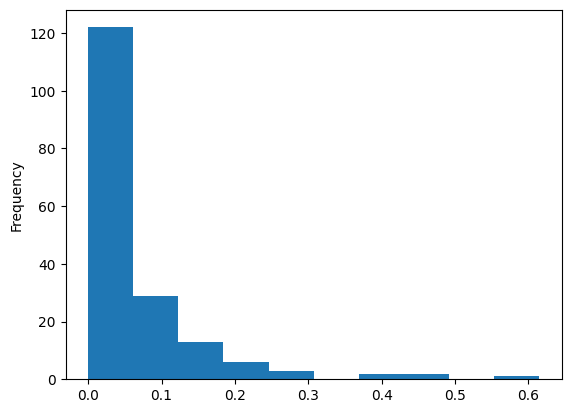

In [ ]:
positive['QA Score'].plot.hist()

# Label through chatGPT

In [ ]:
!pip install openai

In [ ]:
import os
import openai
openai.api_key = os.environ.get('openai_api_key')

system_prompt = "You are a data labeler. You must answer the question 'What is the product's use case in this text?' in less than 30 words. Do not mention any specific companies. Be specific, but do not use a full sentence. Try to only use the text from the prompt. If there is not a use case, send 'None'"

def chat_label(text):
  completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": text}
    ]
  )
  return completion.choices[0].message.content

print(chat_label(" “Despite the sci-fi-like advances in AI like ChatGPT, I believe some of the most valuable business applications from large language models will be from the next wave of process automation (RPA),” Nelson said. That’s because process mining often requires a massive lift on data aggregation, standardization and cleaning. With new AI tools parsing masses of unstructured data, opportunities will open for companies to automate their highly manual workflows."))

Process automation, specifically in process mining, through the use of AI tools to parse unstructured data and automate highly manual workflows.


In [ ]:
use_cases = []
for chunk in tqdm(positive['chunk']):
  use_cases.append(chat_label(chunk))

positive['Use Case'] = use_cases

 22%|██▏       | 40/178 [05:35<19:17,  8.39s/it]


KeyboardInterrupt: ignored

In [ ]:
%store positive

In [ ]:
positive[['title', 'description', 'chunk', 'Use Case', 'url', 'relevancy', 'was_labeled', ]].to_excel('LLMUseCases.xlsx')

# Embed responses and cluster

In [ ]:
positive[positive['Use Case'].str.contains('None')]['Use Case'].unique()

array(['None.',
       'Business Chat integration in Microsoft Teams for preview customers. None regarding Copilot.',
       'None'], dtype=object)

In [ ]:
positive = positive[positive['Use Case'].str.contains('None')]

In [ ]:
resp_vecs = []
for resp in tqdm(positive['Use Case']):
  vec = embedding_model.encode(resp)
  resp_vecs.append(vec)

100%|██████████| 178/178 [00:09<00:00, 19.63it/s]


In [ ]:
vecs = np.stack(resp_vecs)
vecs.shape

(178, 384)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(metric='cosine', linkage='average').fit(vecs)
clustering

AgglomerativeClustering(linkage='average', metric='cosine')

In [ ]:
positive

source                          author  \
8                         CNN           Samantha Murphy Kelly   
32    Harvard Business Review    Marc Zao-Sanders, Marc Ramos   
44           Business Insider  gdean@insider.com (Grace Dean)   
45           Business Insider  gdean@insider.com (Grace Dean)   
101               Gizmodo.com                       Kyle Barr   
...                       ...                             ...   
3607                  PCWorld                    Mark Hachman   
3609                  PCWorld                    Mark Hachman   
3612                  PCWorld                    Mark Hachman   
3616                  PCWorld                    Mark Hachman   
3618                  PCWorld                    Mark Hachman   

                                                  title  \
8     5 jaw-dropping things GPT-4 can do that ChatGP...   
32    A Framework for Picking the Right Generative A...   
44    Bill Gates says that in the future ChatGPT wil...   
45    Bill Gates says that in the future ChatGPT wil...   
101   Khan Academy Head Wants AI to Assist Kids Rath...   
...                                                 ...   
3607  Forget Bing. Microsoft’s radical new Office fe...   
3609  Forget Bing. Microsoft’s radical new Office fe...   
3612  Forget Bing. Microsoft’s radical new Office fe...   
3616  Forget Bing. Microsoft’s radical new Office fe...   
3618  Forget Bing. Microsoft’s radical new Office fe...   

                                            description  \
8     In the first day after it was unveiled, GPT-4 ...   
32    Generative AI has captured the public’s imagin...   
44    Bill Gates said that he expected people to use...   
45    Bill Gates said that he expected people to use...   
101   Sal Khan, the founder of the nonprofit educati...   
...                                                 ...   
3607  Microsoft 365 Copilot’s AI tools don’t seem pa...   
3609  Microsoft 365 Copilot’s AI tools don’t seem pa...   
3612  Microsoft 365 Copilot’s AI tools don’t seem pa...   
3616  Microsoft 365 Copilot’s AI tools don’t seem pa...   
3618  Microsoft 365 Copilot’s AI tools don’t seem pa...   

                                                    url  \
8     https://www.cnn.com/2023/03/16/tech/gpt-4-use-...   
32    https://hbr.org/2023/03/a-framework-for-pickin...   
44    https://www.businessinsider.com/bill-gates-cha...   
45    https://www.businessinsider.com/bill-gates-cha...   
101   https://gizmodo.com/khan-academy-ai-chatbot-gp...   
...                                                 ...   
3607  https://www.pcworld.com/article/1661649/forget...   
3609  https://www.pcworld.com/article/1661649/forget...   
3612  https://www.pcworld.com/article/1661649/forget...   
3616  https://www.pcworld.com/article/1661649/forget...   
3618  https://www.pcworld.com/article/1661649/forget...   

                                             urlToImage           publishedAt  \
8     https://media.cnn.com/api/v1/images/stellar/pr...  2023-03-16T11:59:25Z   
32    https://hbr.org/resources/images/article_asset...  2023-03-29T13:00:54Z   
44    https://i.insider.com/641ad6e68a514c001825bfda...  2023-03-22T11:53:01Z   
45    https://i.insider.com/641ad6e68a514c001825bfda...  2023-03-22T11:53:01Z   
101   https://i.kinja-img.com/gawker-media/image/upl...  2023-03-24T17:50:00Z   
...                                                 ...                   ...   
3607  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   
3609  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   
3612  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   
3616  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   
3618  https://www.pcworld.com/wp-content/uploads/202...  2023-03-17T10:30:00Z   

                                                content  \
8     In the first day after it was unveiled,GPT-4 s...   
32    How to identify th